

```
<Diplodatos 2021>
<Analisis y VIsualizacion de Datos>

<Integrantes de Grupo>
Martin Rodriguez
Luis Juncos
Pablo Carrazana
Martin Peñas
```



#Ejercicio 1 - Analisis descriptivo

# ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

## Lectura del Dataset

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import re
import requests
import scipy.stats
from scipy.stats import chi2_contingency

seaborn.set_context('talk')

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [ ]:
df['salary_monthly_NETO'].describe().apply(lambda s: '{0:.2f}'.format(s))

count       5883.00
mean       94907.95
std        96862.26
min            1.00
25%        51480.00
50%        78000.00
75%       106000.00
max      2080000.00
Name: salary_monthly_NETO, dtype: object

In [ ]:
df.isnull().sum()
df_whitout_nulls = df.dropna(how='any',subset=['salary_monthly_NETO'],axis=0)

##Seleccionar las filas relevantes para analizar. 
Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
* Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
* Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.

Quitamos los salarios en primer lugar por debajo del salario mínimo, vital y movil (SMVM) que conforme lo publicara el MINISTERIO DE PRODUCCIÓN Y TRABAJO CONSEJO NACIONAL DEL EMPLEO, LA PRODUCTIVIDAD Y EL SALARIO MÍNIMO, VITAL Y MÓVIL se encontraba en $ 16875 a partir de Octubre de 2019.


In [ ]:
SMVM= 16875
df=df[df['salary_monthly_NETO']>SMVM]
df.salary_monthly_NETO.describe().round()

count       5643.0
mean       98823.0
std        96976.0
min        17000.0
25%        55000.0
50%        80000.0
75%       108106.0
max      2080000.0
Name: salary_monthly_NETO, dtype: float64

Observamos los cuantiles

In [ ]:
cuant = pd.DataFrame(df['salary_monthly_NETO'].quantile([0.85, 0.90, 0.95, 0.98, 0.99, 0.995, 0.998]))
cuant = cuant.rename_axis('index').reset_index()
cuant["colour"] = 'b', 'g', 'r', 'c', 'm', 'y', 'k'
print(cuant)

   index  salary_monthly_NETO colour
0  0.850            130000.00      b
1  0.900            155000.00      g
2  0.950            220000.00      r
3  0.980            378320.00      c
4  0.990            500000.00      m
5  0.995            650000.00      y
6  0.998            960963.12      k


In [ ]:
#Analizamos recortar la muestra al cuartil 0,995, lo que dejaríamos afuera de la muestra...
out085 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.85)]
out090 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.90)]
out095 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.95)]
out098 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.98)]
out099 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.99)]
out0995 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.995)]
out0998 = df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.998)]

In [ ]:
out_usd = pd.DataFrame()
out_usd["Q085"] = out090["salary_in_usd"].value_counts() / len(out085)
out_usd["Q090"] = out090["salary_in_usd"].value_counts() / len(out090)
out_usd["Q095"] = out095["salary_in_usd"].value_counts() / len(out095)
out_usd["Q098"] = out098["salary_in_usd"].value_counts() / len(out098)
out_usd["Q099"] = out099["salary_in_usd"].value_counts() / len(out099)
out_usd["Q0995"] = out0995["salary_in_usd"].value_counts() / len(out0995)
out_usd["Q0998"] = out0998["salary_in_usd"].value_counts() / len(out0998)

out_usd = out_usd.transpose()

Analizamos de manera gráfica, que % de personas declararon tener su sueldo dolarizado en los cuantiles elegidos. 
Se observa que al tomar como "corte" el cuantil 0,95 dejamos fuera del análisis datos de muestras que declararon un sueldo mayor a $ 210.000 mensuales. A partir de dicho monto, se puede observar que la mayoría declararon que poseen un sueldo dolarizado, los que no son objeto de análisis en este informe. 

<function matplotlib.pyplot.show>

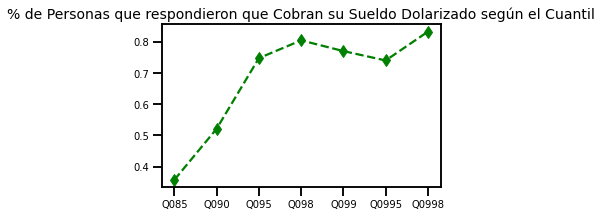

In [ ]:
out_usd = out_usd.rename(columns={"Mi sueldo está dolarizado":"%Dolarizado"})
plt.figure(figsize=(5,3))
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
plt.plot(out_usd["%Dolarizado"], "g--d")
plt.title("% de Personas que respondieron que Cobran su Sueldo Dolarizado según el Cuantil", fontsize=14)
plt.show

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Observando los Cuantiles')

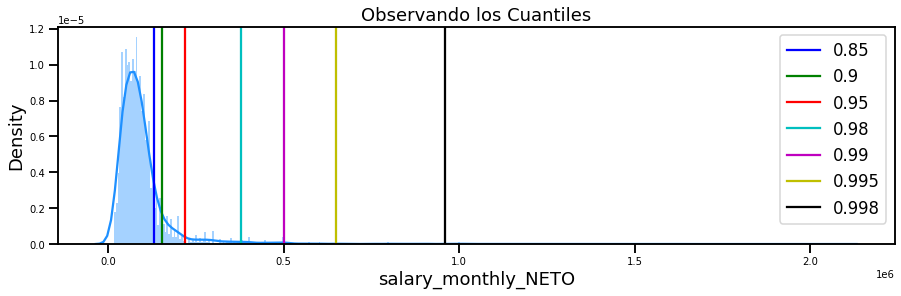

In [ ]:
df.count
plt.figure(figsize=(15,4))
seaborn.distplot(df["salary_monthly_NETO"], bins=400, color="dodgerblue")
for idx in cuant.itertuples():
  plt.axvline(x= idx.salary_monthly_NETO, ymin=0, c= idx.colour, label=idx.index)
plt.legend()
plt.title("Observando los Cuantiles")


Elegimos quitar los datos por encima cuantil 95, del que muchas personas respondieron tener el sueldo dolarizado y por ser montos que se alejan del promedio de la muestra

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


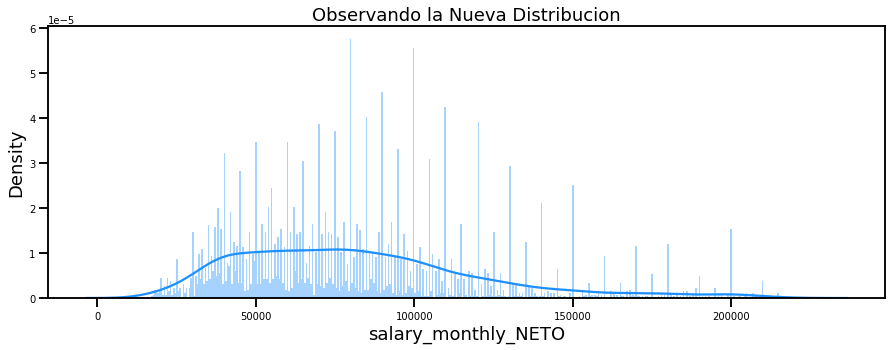

In [ ]:
k = 95
percentile_elegido = df['salary_monthly_NETO'].quantile(k/100)
plt.figure(figsize=(15,5))
plt.title("Observando la Nueva Distribucion")
df_without_outliers = df[df["salary_monthly_NETO"] < percentile_elegido]#[salary_col]
seaborn.distplot(df_without_outliers["salary_monthly_NETO"], bins=400, color='dodgerblue')

##Selección de columnas relevantes para analizar

In [ ]:
df = df_without_outliers
df['work_role']=='Developer'

0       False
1        True
2       False
3       False
4        True
        ...  
6088    False
6089    False
6090     True
6091    False
6094    False
Name: work_role, Length: 5355, dtype: bool

In [ ]:
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'work_role']

##Preparación de datos: todo lo necesario para facilitar la manipulación de datos y estudio de variables.

In [ ]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,work_role,cured_programming_languages
0,ninguno,Ninguno,43000.0,Consultant,[ninguno]
1,html,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]"
2,ninguno,Ninguno,127000.0,Infosec,[ninguno]


### Análisis de sub-población

* Seleccionaría de la columna word_role solo desarrolladores ya que consideramos que es la subpobablación cuyo salarío tiene relación directa con su expertise en programación.



In [ ]:
df_lang['work_role'].unique() ##Encontramos Developer y Desarrollador en un mismo respuesta junto a otros roles

array(['Consultant', 'Developer', 'Infosec', 'SysAdmin / DevOps / SRE',
       'Manager / Director', 'Technical Leader',
       'Data Scientist / Data Engineer', 'DBA', 'Project Manager',
       'Business Analyst', 'QA / Tester', 'Architect', 'Product Manager',
       'Designer', 'BI Analyst / Data Analyst', 'Middleware',
       'Storage / Backup', 'Networking', 'HelpDesk', 'UX',
       'Ux User Research Analyst', 'Sales / Pre-Sales', 'Team leader',
       'Microinformatica', 'Technical Writer',
       'Implementadora de software ', 'Desarrollador BI',
       'Martech Specialist', 'Maquetador/Diseño UI', 'Service manager',
       'Release Manager', 'Access Management Analyst',
       'DevOps Cloud Engineer', 'Soporte e Infraestructura',
       'Recruiter / HR', 'Finance', 'Data Visualization',
       'Implementador de Software', 'back end', 'Software Engineer',
       'Scrum Master', 'NLP', 'Presales architect', 'NOC',
       'QA automation Technical Leader', 'Telecomunicaciones', 'Cto

Hacemos curacion del campo work_role, todo en minuscula en una columna nueva work_role_clean

In [ ]:
df_lang['work_role_clean'] = df_lang['work_role'].apply(lambda x: str.lower(x))

In [ ]:
df_lang.head(3)

,programming_language,tools_programming_languages,salary_monthly_NETO,work_role,cured_programming_languages,work_role_clean
0,ninguno,Ninguno,43000.0,Consultant,[ninguno],consultant
1,html,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer
1,javascript,"HTML, Javascript, Python",63000.0,Developer,"[html, javascript, python]",developer


Buscamos todos los que respondieron developer y desarrollador

In [ ]:
df_developer = df_lang[df_lang['work_role_clean'].str.contains("developer|desarrollador")]

In [ ]:
df_developer['work_role_clean'].value_counts()

developer                                                                                                                       7799
firmware developer                                                                                                                10
desarrollador  / líder técnico / analista técnico funcional                                                                        6
analista/desarrollador                                                                                                             6
trabajo como desarrollador back, pero también tengo que estar haciendo de analista , dba, dev frontend y a veces de helpdesk       6
software developer- computer vision full stack                                                                                     5
full developer                                                                                                                     4
help desk/software architect/developer                               

Analizamos los 10 lenguajes mas populares dentro del dataset

In [ ]:
df_lang_work = df_developer
language_count = df_lang_work.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
most_important_lang = language_count[:10]
most_important_lang

,language,frequency
0,javascript,1395
1,html,967
2,sql,906
3,css,734
4,java,711
5,typescript,493
6,.net,421
7,c#,408
8,php,363
9,python,342


Armamos dataset con estos 10 lenguajes mas populares

In [ ]:
selection = most_important_lang['language'].to_list()

In [ ]:
mask = df_lang_work['programming_language'].apply(lambda x: any(item for item in selection if item in x))
df_lang_work_10 = df_lang_work[mask]

In [ ]:
df_lang_work_10['programming_language'].value_counts()

javascript    1395
html           967
sql            906
css            734
java           711
typescript     493
.net           421
c#             408
php            363
python         342
pl/sql           9
plsql            4
Name: programming_language, dtype: int64

Armamos dataset con los lenguajes mas demandados segun https://octoverse.github.com/#chart-rely-on-oss

In [ ]:
mas_demandados= ['php','java','javascript','.net','python','ruby']

In [ ]:
mask_2 = df_lang_work['programming_language'].apply(lambda x: any(item for item in mas_demandados if item in x))
df_lang_work_dem = df_lang_work[mask_2]

In [ ]:
order = pd.DataFrame(df_lang_work_dem['programming_language'].value_counts()).index

In [ ]:
df_lang_work_dem.columns

Index(['programming_language', 'tools_programming_languages',
       'salary_monthly_NETO', 'work_role', 'cured_programming_languages',
       'work_role_clean'],
      dtype='object')

## Selección de métricas
Opcion elegida: Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.

In [ ]:
df_lang_work_dem.columns

Index(['programming_language', 'tools_programming_languages',
       'salary_monthly_NETO', 'work_role', 'cured_programming_languages',
       'work_role_clean'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


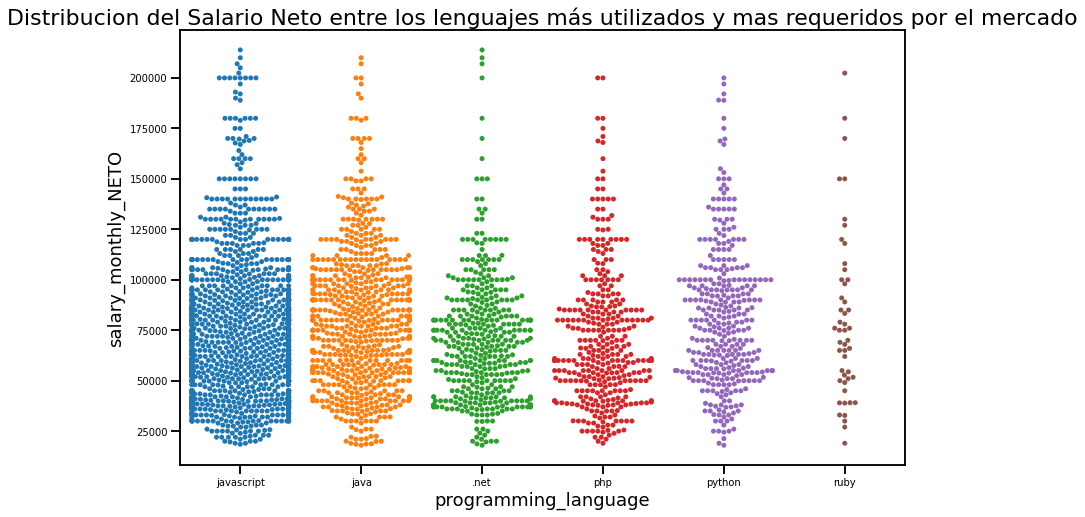

In [ ]:
plt.figure(figsize=(13,8))
plt.title("Distribucion del Salario Neto entre los lenguajes más utilizados y mas requeridos por el mercado", fontsize=22)
seaborn.swarmplot(x="programming_language", y="salary_monthly_NETO", data=df_lang_work_dem, order=order)

# Ejercicio 2



##Histograma

In [ ]:
#seleccionamos la columnas relevantes a analizar
columnas_relevantes = ['salary_monthly_NETO','work_role','profile_years_experience','salary_satisfaction','work_province','profile_studies_level','tools_programming_languages','salary_in_usd','profile_age']

In [ ]:
#eliminación de datos NaN, erroneo y extremos. 
#1) evaluamos columnas con NaN que nos importen y borramos las filas. 
df[columnas_relevantes].isna().sum()

salary_monthly_NETO               0
work_role                         0
profile_years_experience          0
salary_satisfaction               0
work_province                     0
profile_studies_level             0
tools_programming_languages       1
salary_in_usd                  4952
profile_age                       0
dtype: int64

In [ ]:
#previo a borrar todos los NaN, lo que es salary_in_usd vamos a reemplazar el string Mi sueldo está dolarizado por un Si y los NaN con un No
df['salary_in_usd'].fillna('No',inplace=True)
df['salary_in_usd'] = df['salary_in_usd'].str.replace('Mi sueldo está dolarizado','Si')

In [ ]:
df[columnas_relevantes].isna().sum()

salary_monthly_NETO            0
work_role                      0
profile_years_experience       0
salary_satisfaction            0
work_province                  0
profile_studies_level          0
tools_programming_languages    1
salary_in_usd                  0
profile_age                    0
dtype: int64

In [ ]:
#borrarmos todos los NaN. El único caso en tools_programming lo borramos porque necesitamos datos con lenguages de programación. 
df.dropna(subset=columnas_relevantes,inplace=True)

In [ ]:
#2) Análisis de cada columna y búsqueda de valores extraños
df[columnas_relevantes].describe().round()

,salary_monthly_NETO,profile_years_experience,salary_satisfaction,profile_age
count,5354.0,5354.0,5354.0,5354.0
mean,82170.0,9.0,3.0,42.0
std,37935.0,7.0,1.0,710.0
min,17000.0,0.0,1.0,18.0
25%,53784.0,3.0,2.0,27.0
50%,77000.0,7.0,3.0,31.0
75%,102000.0,13.0,3.0,37.0
max,216000.0,115.0,4.0,52000.0


In [ ]:
#alguna obviedades:
#vamos a separar los salarios en primer lugar por debajo del salario mínimo, vital y movil (SMVM) que es de $ 16875  
df_under_SMVM = df[df['salary_monthly_NETO']<16875]
df = df[df['salary_monthly_NETO']>16875]
df.salary_monthly_NETO.describe().round()

count      5354.0
mean      82170.0
std       37935.0
min       17000.0
25%       53784.0
50%       77000.0
75%      102000.0
max      216000.0
Name: salary_monthly_NETO, dtype: float64

In [ ]:
#analizamos los casos con años de experiencia por arriba de 40 años
df[df['profile_years_experience']>40]
#3 casos. Uno con 115 años de exp, el resto tiene relación con la edad y está correcto.
#nos quedamos con casos < 50 años
df = df[df['profile_years_experience']<50]

In [ ]:
#analizamos los casos de edades por arriba de 70 años
df[df['profile_age']>70]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,cured_programming_languages
1659,Hombre,567,Argentina,Ciudad Autónoma de Buenos Aires,20.0,15.0,3.0,6,Universitario,Completado,Ingeniería en Sistemas de Información,UADE - Universidad Argentina De la Empresa,"Sí, de forma particular",No,Sí,Hombre orquesta,"Linux, Windows Server","Bash/Shell, CSS, HTML, Python, Asp","Bootstrap, Flask","MariaDB, MySQL, PostgreSQL, SQLite",Ninguna,"Android Studio, Nano, Visual Studio Code",GNU/Linux,Android,"Sí, pasiva",0.0,Porcentaje de mi sueldo,Full-Time,130000.0,100000.0,No,3,3,De uno a tres sueldos,Performance de la compañía,No,0.0,0,En mi trabajo actual,¿Qué les importa?,Social,Sí,2001-5000,Otras industrias,3,1,Ninguna de las anteriores,NaN,"[bash/shell, css, html, python, asp]"
5752,Hombre,52000,Argentina,Jujuy,9.0,9.0,9.0,3,Universitario,Completado,Analista Programador Universitario,UNJu - Universidad Nacional de Jujuy,No,Sí,Sí,Developer,"Amazon Web Services, Docker, Linux, Windows Se...","HTML, Java, Javascript, SQL",".NET Core, Angular, Flutter, Hibernate, jQuery...","MariaDB, Microsoft SQL Server, MongoDB, MySQL,...","JUnit, Postman","Eclipse, IntelliJ, Visual Studio, Visual Studi...",Windows,Android,No,0.0,Neto,Full-Time,40000.0,52000.0,No,3,3,No,No recibo bono,Dos,25.0,7,Jamás,Heterosexual,Visual,No,11-50,Servicios / Consultoría de Software / Digital,8,8,Horarios flexibles,NaN,"[html, java, javascript, sql]"


##Densidad conjunta
Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos?

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa



*   Para variables categóricas: tabla de contingencia. Evaluaremos el work_role (Developer o No) y el nivel Universitario. 
*   Para variables numéricas: covairanza y correlación.




##Análisis del Rol en el Trabajo vs Nivel Universitario


Es interesante evaluar el aspecto que los desarrolladores adquieren este role en una edad menor al resto de los roles (ver boxenplot) y como se observa en el crosstab hay una gran concentración de desarrolladores en nivel terciario y universitario. 

In [ ]:
df['developer_and_others']=np.where(df['work_role']=='Developer','Developer','Not Developer')
pd.crosstab(df.developer_and_others, df.profile_studies_level)#, normalize=True)

profile_studies_level,Doctorado,Posdoctorado,Posgrado,Primario,Secundario,Terciario,Universitario
developer_and_others,,,,,,,
Developer,7,0,35,1,110,400,1557
Not Developer,15,2,245,1,288,624,2068


count     2110.000000
mean        54.356398
std       1131.409841
min         18.000000
25%         25.000000
50%         29.000000
75%         33.000000
max      52000.000000
Name: profile_age, dtype: float64

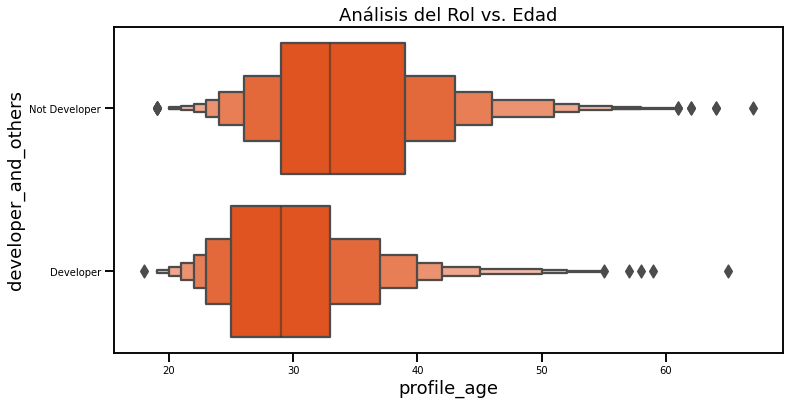

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Análisis del Rol vs. Edad")
seaborn.boxenplot(data=df[df.profile_age < 70], x='profile_age', y='developer_and_others',color='orangered')
plt.ticklabel_format(style='plain', axis='x')
df[df['work_role']=='Developer'].profile_age.describe()

##Análisis de Años de Experiencia vs Salario Neto.
En primer lugar, es importante resaltar mediante el siguiente scatter que los mayores salarios son aquellos dolarizados y los dejaremos de lado para el siguiente análisis.


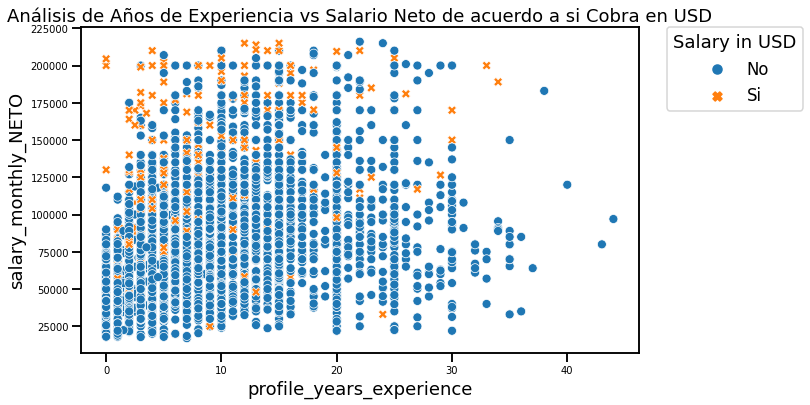

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Análisis de Años de Experiencia vs Salario Neto de acuerdo a si Cobra en USD")
seaborn.scatterplot(data = df, x = 'profile_years_experience', y = 'salary_monthly_NETO',
                    hue = 'salary_in_usd', style = 'salary_in_usd')
plt.legend(bbox_to_anchor = (1.05,1), loc = 2, borderaxespad = 0., title = 'Salary in USD')

Si separamos Desarrolladores de No Desarrolladores, se revela una mayor concentración de salarios más altos para No Desarrolladores. 

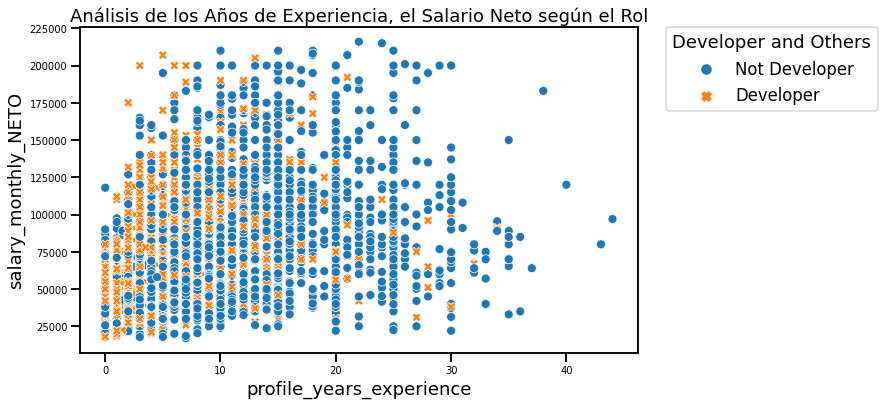

In [ ]:
df_no_usd_salary = df[df['salary_in_usd'] == 'No']
plt.figure(figsize = (10,6))
plt.title("Análisis de los Años de Experiencia, el Salario Neto según el Rol")
seaborn.scatterplot(data = df_no_usd_salary,x = 'profile_years_experience',y = 'salary_monthly_NETO', 
                    hue ='developer_and_others',style = 'developer_and_others')
plt.legend(bbox_to_anchor = (1.05,1), loc = 2,borderaxespad = 0.,title='Developer and Others')

Teniendo en cuenta que los No Desarrollaores tienen salarios más altos (al menos algunos casos), eliminamos el percentil 90. En la siguiente gráfica, donde comparamos salario NETO de Desarrolladores vs No Desarrollares, es interesante resalatar que los desarrollares tienen mejores salario en menos años de experiencia. 
El Histoplot muesta similitud entre salarios y Desarrollares y No Desarrollares. Y el último Histoplot muestra mayor concentración de Desarrolladores en menos años de experiencia. 

In [ ]:
k = 90
salary_col='salary_monthly_NETO'
percentile_90 = df[salary_col].quantile(k / 100)
n_below = len(df[df[salary_col] < percentile_90])
n_above = len(df[df[salary_col] > percentile_90])
print('Percentil {} de la columna {}: {}'.format(k, salary_col, percentile_90))
print('% de datos menor que percentil {}: {}'.format(k, n_below / len(df)))
print('% de datos mayor que percentil {}: {}'.format(k, n_above / len(df)))
df_without_percentil_90 = df[df[salary_col] < percentile_90]

Percentil 90 de la columna salary_monthly_NETO: 130000.0
% de datos menor que percentil 90: 0.8858583971604708
% de datos mayor que percentil 90: 0.09994395665981692


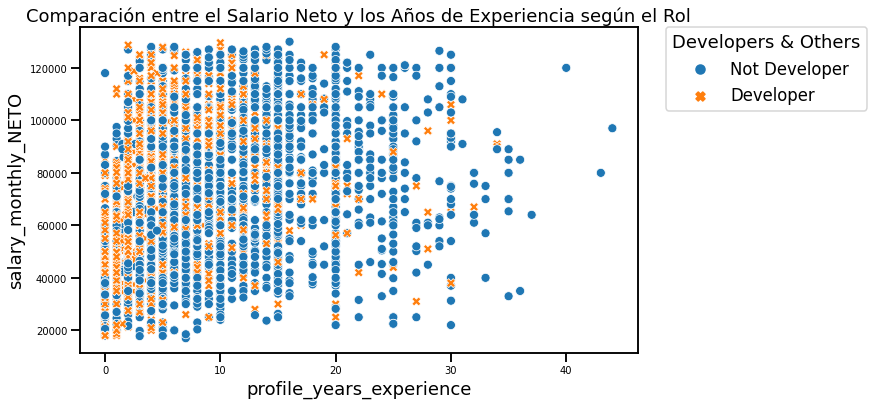

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Comparación entre el Salario Neto y los Años de Experiencia según el Rol")
seaborn.scatterplot(data = df_without_percentil_90,x = 'profile_years_experience',y='salary_monthly_NETO',hue='developer_and_others',style='developer_and_others')
plt.legend(bbox_to_anchor = (1.05,1),loc=2,borderaxespad = 0.,title = 'Developers & Others')

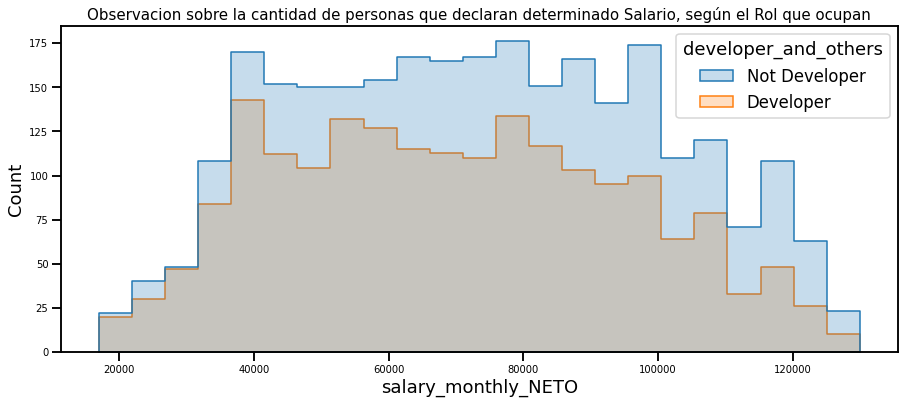

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Observacion sobre la cantidad de personas que declaran determinado Salario, según el Rol que ocupan", fontsize=15)
seaborn.histplot(df_without_percentil_90, x="salary_monthly_NETO", hue="developer_and_others", element="step")

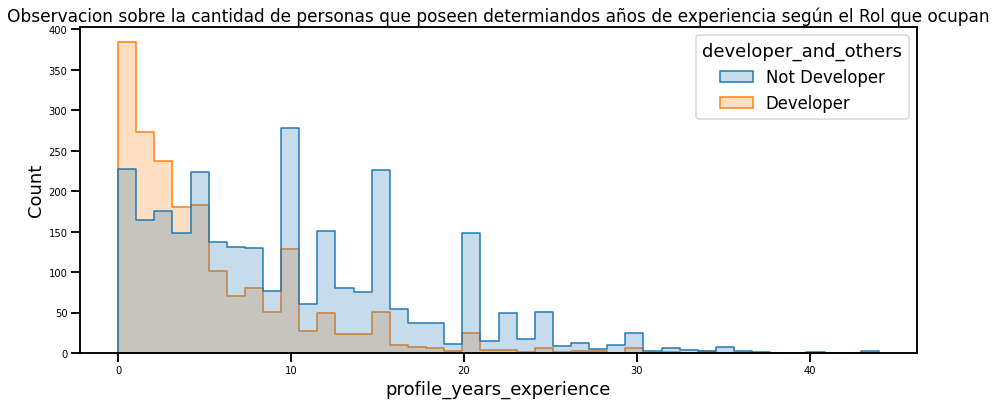

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Observacion sobre la cantidad de personas que poseen determiandos años de experiencia según el Rol que ocupan", fontsize=17)
seaborn.histplot(df_without_percentil_90, x="profile_years_experience", hue="developer_and_others", element="step")

##**Asociación**
Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple. ¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría

In [ ]:
#eliminamos el percentil 90 del salario BRUTO, como hicimos en el NETO. 
percentile_90 = df_without_percentil_90['salary_monthly_BRUTO'].quantile(k / 100)
df_without_percentil_90_BRUTO=df_without_percentil_90[df_without_percentil_90['salary_monthly_BRUTO'] < percentile_90]

En el siguiente scatter graficamos salario NETO vs salario BRUTO. Además incluimos 3 curvas más: f(x)=x, f(x)=1.17x, f(x)=1.5x
La primera, verde en el gráfico, es cuando NETO y BRUTO son iguales. Podría ser el caso de freelance. El segundo scatterplot incluye solo freelance; es dificil entender que incluyen en el bruto un freelance. Podría ser desde obra social, a seguros de vida, e infinitas opciones más.
La segunda curva, en rojo, es el porcentaje mínimo (1.17) de un empleado en relación de dependencia. Y que puede llegar a 1.5 (curva amarilla) y hasta superarlo dependiendo de por ejemplo una obra social prepaga para todo su grupo familiar. 
Los valores por dejabo de la curva verde no tienen mucha lógica: NETO > BRUTO y equivalen al 2.63%. 

In [ ]:
#salarios NETO > BRUTO, que no tienen lógica. 
100*len(df[(df.salary_monthly_NETO) > (df.salary_monthly_BRUTO)])/len(df)

2.577993648421446

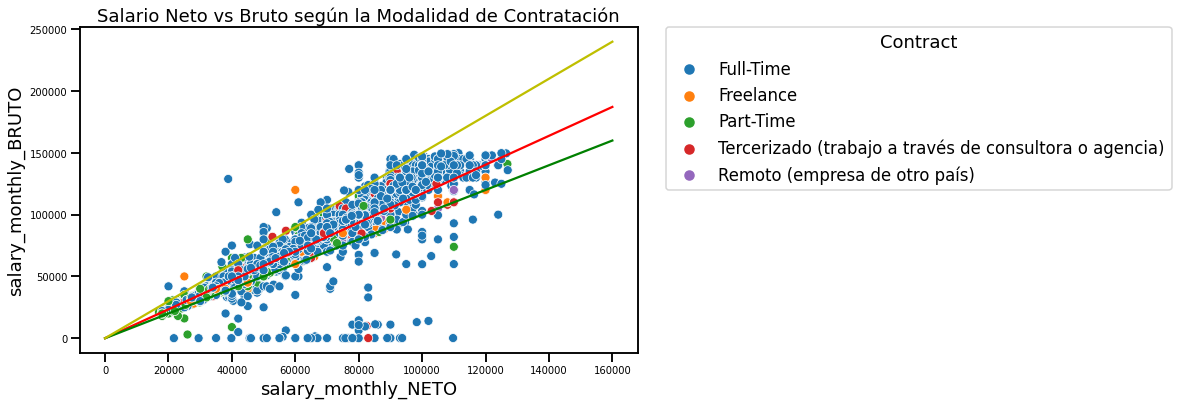

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Salario Neto vs Bruto según la Modalidad de Contratación", fontsize=18)
seaborn.scatterplot(data = df_without_percentil_90_BRUTO, x = 'salary_monthly_NETO', y = 'salary_monthly_BRUTO', hue = 'work_contract_type')
plt.legend(bbox_to_anchor = (1.05,1),loc = 2,borderaxespad = 0., title = 'Contract')
X_plot = np.linspace(0,160000)
Y_plot = X_plot*1.17
plt.plot(X_plot, Y_plot, color='r')
Y2_plot = X_plot
plt.plot(X_plot, Y2_plot, color='g')
Y3_plot = X_plot*1.5
plt.plot(X_plot, Y3_plot, color='y')
plt.show()

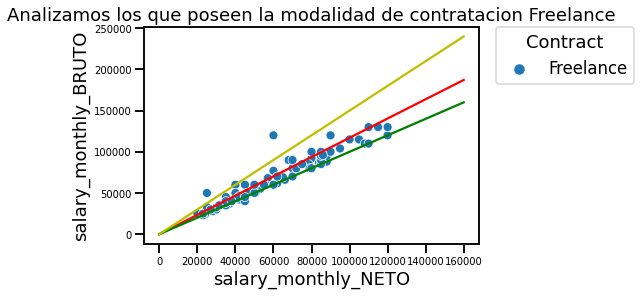

In [ ]:
solo_freelance=df_without_percentil_90_BRUTO[df_without_percentil_90_BRUTO['work_contract_type']=='Freelance']
seaborn.scatterplot(data = solo_freelance, x = 'salary_monthly_NETO',y = 'salary_monthly_BRUTO', hue = 'work_contract_type')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='Contract')
plt.title("Analizamos los que poseen la modalidad de contratacion Freelance", fontsize=18)
X_plot = np.linspace(0,160000)
Y_plot = X_plot*1.17
plt.plot(X_plot, Y_plot, color='r')
Y2_plot = X_plot
plt.plot(X_plot, Y2_plot, color='g')
Y3_plot = X_plot*1.5
plt.plot(X_plot, Y3_plot, color='y')
plt.show()

Conclusión: incluiría el salario Bruto, pero para la subpoblación de full time con Bruto >= NETO. Que corresponden a 84% de los datos. 

**Densidad condicional**




Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable 'salary_monthly_NETO' ¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación

In [ ]:
df.profile_studies_level.value_counts(normalize=False)

Universitario    3625
Terciario        1024
Secundario        398
Posgrado          280
Doctorado          22
Primario            2
Posdoctorado        2
Name: profile_studies_level, dtype: int64

Se seleccionan las dos subpoblaciones mas numerosas de la variable aleatoria profile_studies_level "Universitarios y Terciario".

In [ ]:
df['Universitarios_and_Terciarios']=np.where(df['profile_studies_level']=='Universitario','Universitario',np.where(df['profile_studies_level']=='Terciario','Terciario','NA'))
pd.crosstab(df.Universitarios_and_Terciarios, df.profile_studies_level)#, normalize=True)

profile_studies_level,Doctorado,Posdoctorado,Posgrado,Primario,Secundario,Terciario,Universitario
Universitarios_and_Terciarios,,,,,,,
NA,22,2,280,2,398,0,0
Terciario,0,0,0,0,0,1024,0
Universitario,0,0,0,0,0,0,3625


Se crea DF solo con universitarios y terciarios.

In [ ]:
df_univ_terc=df.copy()
df_univ_terc=df_univ_terc.drop(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=="NA"].index)
df_univ_terc=df_univ_terc[df_univ_terc[salary_col] < percentile_90]
df_univ_terc.head()

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,cured_programming_languages,developer_and_others,Universitarios_and_Terciarios
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,No,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN,[ninguno],Not Developer,Universitario
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,No,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,"[html, javascript, python]",Developer,Universitario
4,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,9.0,6.0,6.0,0,Universitario,En curso,Licenciatura en Ciencias dela Computación,UBA - Universidad de Buenos Aires,No,No,Sí,Developer,Amazon Web Services,"CSS, HTML, Javascript, SQL, TypeScript","Angular, Node.js","Amazon DynamoDB, MongoDB, MySQL",Jest,Vim,macOS,Android,No,0.0,Porcentaje de mi sueldo,Full-Time,140000.0,106000.0,No,1,1,Menos de un sueldo,Performance individual,No,0.0,0,Jamás,Heterosexual,NaN,NaN,11-50,Servicios / Consultoría de Software / Digital,6,6,"Clases de idiomas, Horarios flexibles, Vacacio...",NaN,"[css, html, javascript, sql, typescript]",Developer,Universitario
5,Hombre,25,Argentina,Ciudad Autónoma de Buenos Aires,1.0,0.0,0.0,0,Terciario,Incompleto,Tecnicatura Superior en Programación,UTN - Universidad Tecnológica Nacional,No,No,Sí,Developer,Ninguna,"Java, Javascript","Node.js, React.js, Spark",MySQL,"Jest, JUnit, Postman","IntelliJ, Visual Studio Code",macOS,Android,No,0.0,Bruto,Full-Time,54000.0,44000.0,No,2,2,No,No recibo bono,Uno,15.0,5,Jamás,Heterosexual,NaN,No,10001+,Producto basado en Software,8,8,"Clases de gimnasia online, Clases de idiomas, ...",NaN,"[java, javascript]",Developer,Terciario
6,Hombre,33,Argentina,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,Incompleto,Ingeniería en Informática,UBA - Universidad de Buenos Aires,"Sí, de forma particular, Sí, los pagó un emple...",Sí,Sí,Developer,"Amazon Web Services, Docker, Linux, Serverless",Javascript,Node.js,"MongoDB, MySQL, Redis",Postman,Visual Studio Code,GNU/Linux,Android,No,0.0,Porcentaje de mi sueldo,F

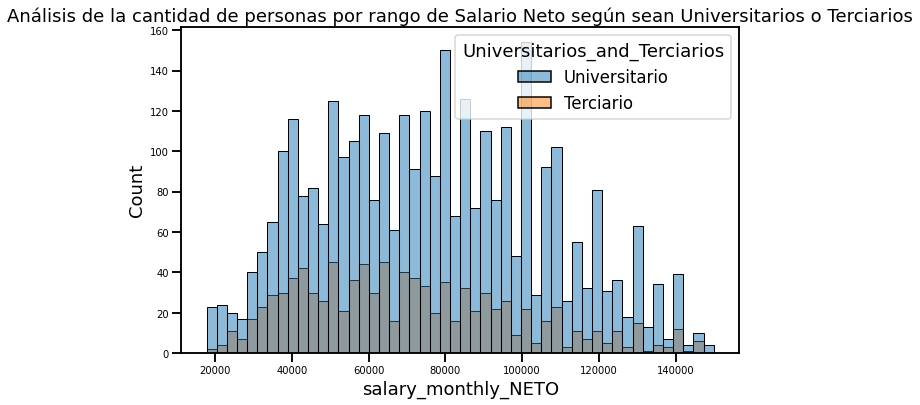

In [ ]:
#Histograma comparativo entre salario neto y bivel de estudio incluyendo la subpablocion seleccionada.
plt.figure(figsize=(10,6))
plt.title("Análisis de la cantidad de personas por rango de Salario Neto según sean Universitarios o Terciarios", fontsize=18)
seaborn.histplot(df_univ_terc, x="salary_monthly_NETO", hue="Universitarios_and_Terciarios", bins=50)

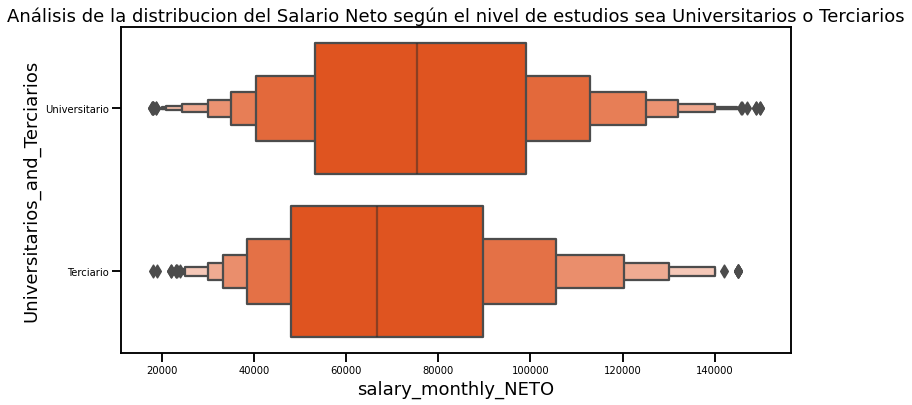

In [ ]:
#Se realiza grafico de caja relacionando la subpoblacion seleccionada consalario neto
plt.figure(figsize=(12, 6))
plt.title("Análisis de la distribucion del Salario Neto según el nivel de estudios sea Universitarios o Terciarios", fontsize=18)
seaborn.boxenplot(data=df_univ_terc, x='salary_monthly_NETO', y='Universitarios_and_Terciarios',color='orangered')
plt.ticklabel_format(style='plain', axis='x')

Se observa que la distribucion (histograma y boxplot)

---

de ambas subpoblaciones son similares, en el caso de los Universitarios se logra salario mayores comparando los cuartiles 25 al 75.



Para el analisis se agrega una nueva variable aleatoria categorica en relacion al salario neto, es "is_above_avg_salary_neto", donde se indica si el salario es mayor al promedio, lo valores posibles son "Si" y "No"

In [ ]:
#Se agrega la nueva variable aleatoria is_above_avg_salary_neto

avg_salary=df_univ_terc.salary_monthly_NETO.mean()
df_univ_terc['is_above_avg_salary_neto']=np.where(df_univ_terc['salary_monthly_NETO'] > avg_salary,'Si','No')


In [ ]:
#Calculo probabilidad de tener nivel de estudio Universitario
p_universitario = len(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=="Universitario"]) / len(df_univ_terc)
avg_salary=df_univ_terc.salary_monthly_NETO.mean()
p_universitario


0.7760679834634818

In [ ]:
#Calculo probabilidad de ganar mas que el promedio del salario neto
p_above_avg = len(df_univ_terc[df_univ_terc['salary_monthly_NETO'] >= avg_salary]) / len(df_univ_terc)
p_above_avg

0.4731281580156178

In [ ]:
#Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Universitario"
p_intersection_count = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count

0.38768948093706934

In [ ]:
#Calculamos la probabilidad de ser terciario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Terciario"
p_intersection_count_terciario = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario

0.08543867707854846

In [ ]:
#Calculamos la probabilidad de ser terciario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Terciario"
p_intersection_count_terciario_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario_menos

0.13849333945796968

In [ ]:
#Calculamos la probabilidad de ser universitario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_and_Terciarios=="Universitario"
p_intersection_count_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_menos

0.3883785025264125

Verificamos la condicion de independencia planteada.

¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto?
Se realiza el siguiente planteo:

Sean A y B se dicen conjuntos independientes si:

P(A∩B)=P(A)P(B)

Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio.

P(A∩B)=0.38561347598452084

P(A)P(B)=0.7776007284315957x0.4693831094923742=0.364989888


No se cumple la condicion de independencia, nos da una idea de que las variables estan relacionadas.

P(B)!=0 -> P(A|B)=P(A)


donde P(A|B)=P(A∩B)/P(B)

Test Chi-Cuadrado  p/ independencia de v.a. categóricas

H0=”las dos variables en estudio son independientes”

H1=”las dos variables en estudio están relacionadas”

In [ ]:
#Se realiza la tabla de contingencia
tab_conting = pd.crosstab(df_univ_terc.Universitarios_and_Terciarios, df_univ_terc.is_above_avg_salary_neto)#, margins=true)
tab_conting

is_above_avg_salary_neto,No,Si
Universitarios_and_Terciarios,,
Terciario,603,372
Universitario,1691,1688


Calculamos test chi-cuadrado.

In [ ]:
test= chi2_contingency(tab_conting)

#los valores esperados son:
esperados = pd.DataFrame(test[3])
esperados

,0,1
0,513.700046,461.299954
1,1780.299954,1598.700046


In [ ]:
#P-Valor
print ("el P valor es:", test[1])

el P valor es: 1.0080009726461335e-10


Tomando un nivel de significancia aplha=0,05 y contrastando con el P-valor obtenido se concluye que se rechaza la hipotesis H0, las variables comparadas no son independientes.

Calculo de medidas de centralizacion y dispersion para cada subpoblacion.

In [ ]:
#calculamos la media, mediana y maximo del Salario Neto con nivel estudio Terciario
medidas_centralizacion_univ=df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.mean(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.median(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.max()
print("Media, Mediana, Maximo")
medidas_centralizacion_univ

Media, Mediana, Maximo


(70469.44841025642, 66612.0, 145000.0)

In [ ]:
#calculamos la media y mediana del Salario Neto con nivel estudio Univercitario
medidas_centralizacion_terc=df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.mean(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.median(), df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.max()
print("Media, Mediana, Maximo")
medidas_centralizacion_terc

Media, Mediana, Maximo


(76787.049934892, 75281.0, 149900.0)

In [ ]:
#Medidas de dispersion
df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.describe()

count      3379.000000
mean      76787.049935
std       29160.209384
min       17800.000000
25%       53285.000000
50%       75281.000000
75%       98992.000000
max      149900.000000
Name: salary_monthly_NETO, dtype: float64

In [ ]:
df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO.describe()

count       975.000000
mean      70469.448410
std       28218.633728
min       18000.000000
25%       48000.000000
50%       66612.000000
75%       89750.000000
max      145000.000000
Name: salary_monthly_NETO, dtype: float64

In [ ]:
print("Coeficiente de variación salario neto de los Terciario",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO))
print("Coeficiente de variación salario neto de los Universitarios",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO.dropna()))

Coeficiente de variación salario neto de los Terciario 0.40023243487294025
Coeficiente de variación salario neto de los Universitarios 0.37969806331263656


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


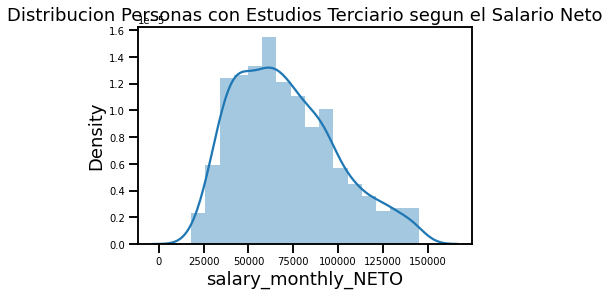

In [ ]:
plt.title("Distribucion Personas con Estudios Terciario segun el Salario Neto")
seaborn.distplot(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Terciario'].salary_monthly_NETO)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


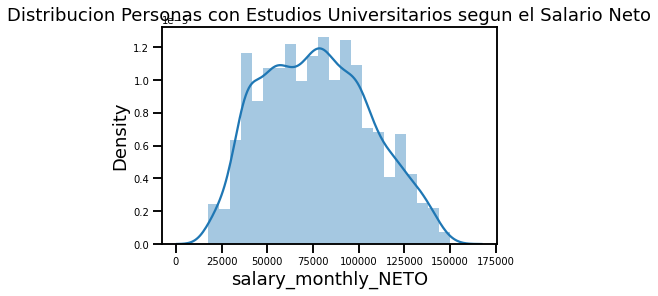

In [ ]:
plt.title("Distribucion Personas con Estudios Universitarios segun el Salario Neto")
seaborn.distplot(df_univ_terc[df_univ_terc['Universitarios_and_Terciarios']=='Universitario'].salary_monthly_NETO)

En general se observa que ambas subpoblaciones tienen distribuciones similares con desviacion estandar y coeficiente de variacion aproximadas respecto al salario neto. La subpoblacion Universitarios tiene mas personas dentro de los encuestados. En promedio los Universitarios tienen mayor sueldo que los Terciarios aunque el salario maximo obtenido es similar dentro del percentil 90 de la variable salario neto.


d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)

Se selecciona variable categorica profile_open_source_contributions, y las numericas profile_years_experience, salary_monthly_NETO.

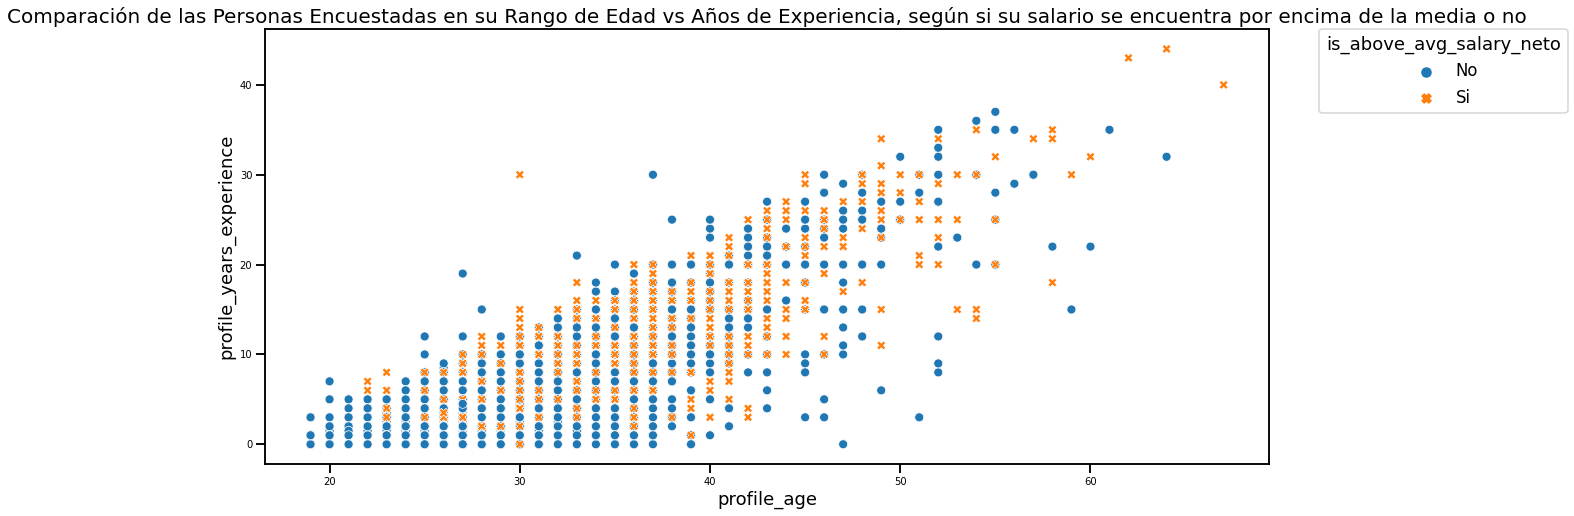

In [ ]:
edad=df_univ_terc[df_univ_terc['profile_age']<70]
plt.figure(figsize=(18,8))
plt.title("Comparación de las Personas Encuestadas en su Rango de Edad vs Años de Experiencia, según si su salario se encuentra por encima de la media o no", fontsize=20)
seaborn.scatterplot(data=edad,x='profile_age',y='profile_years_experience',hue='is_above_avg_salary_neto',style='is_above_avg_salary_neto')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,title='is_above_avg_salary_neto')

Se observa que las personas con mas de 10 años experiencia laboral tienen en su mayoria mas de 30 años y obtienen sueldos mayor al sueldo neto promedio.